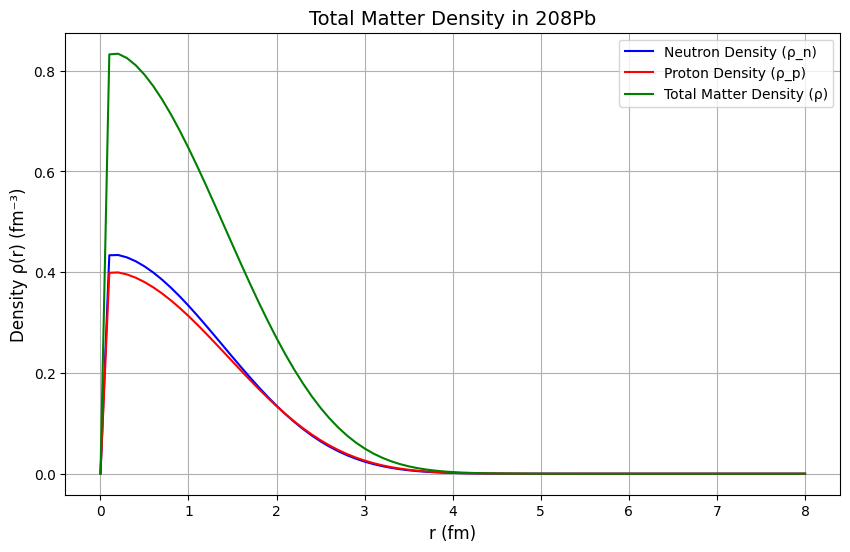

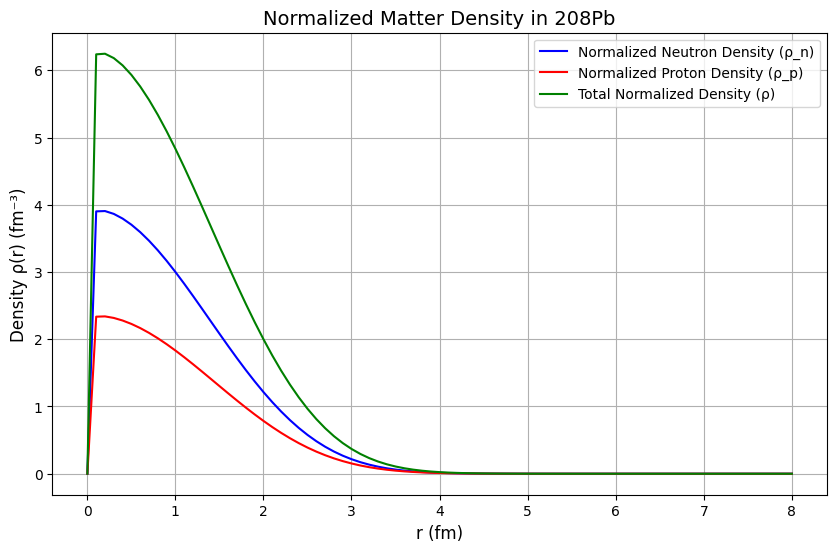

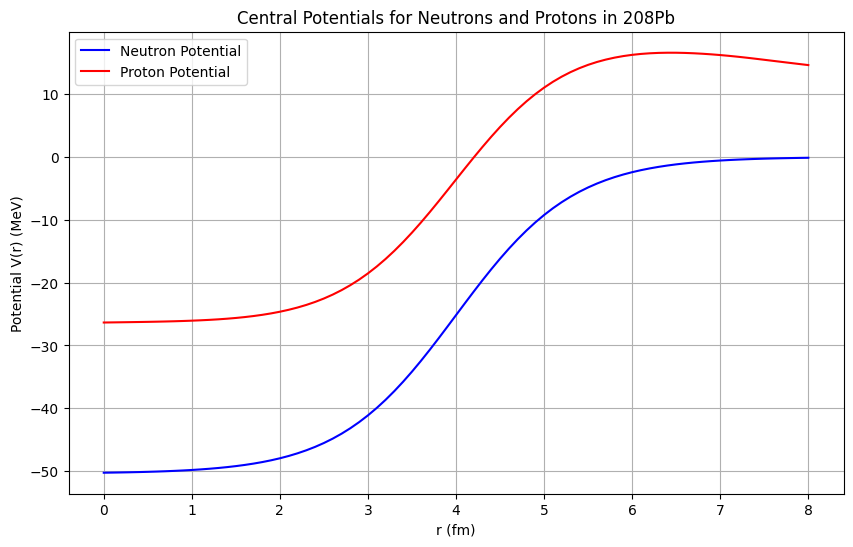

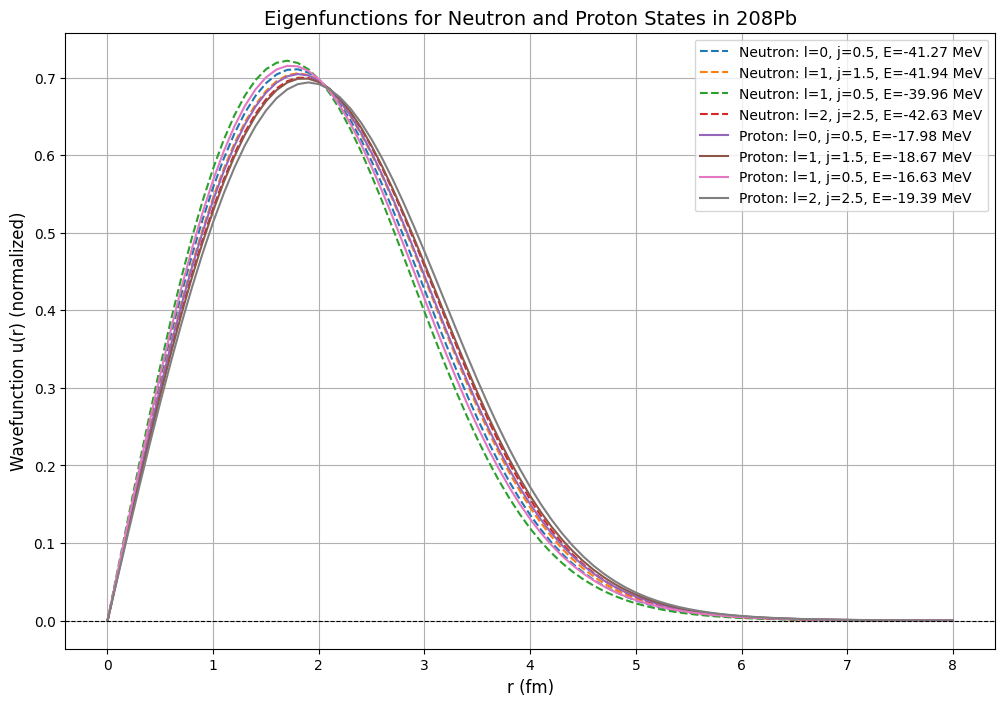

Neutron Eigenvalues (MeV):
l=0, j=0.5: E=-41.27
l=1, j=1.5: E=-41.94
l=1, j=0.5: E=-39.96
l=2, j=2.5: E=-42.63

Proton Eigenvalues (MeV):
l=0, j=0.5: E=-17.98
l=1, j=1.5: E=-18.67
l=1, j=0.5: E=-16.63
l=2, j=2.5: E=-19.39


In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Constants and parameters
hbar2_over_2m = 20.75  # MeV·fm²
V0 = 50.4  # MeV (central potential depth for neutrons in 208Pb)
R = 4.0  # fm (radius of the Wood-Saxon potential)
a = 0.67  # fm (diffuseness parameter)
r0 = 1.27  # fm
V_ls = 0.44 * V0  # Spin-orbit coupling strength
h = 0.1  # fm (mesh size)
tolerance = 1e-6  # Energy convergence criterion

# Proton parameters
Z = 82  # Proton number
e2 = 1.44  # MeV·fm (electric charge squared)
Rc = 1.25 * (208**(1/3))  # fm (charge radius)

# Wood-Saxon potential
def V_ws(r):
    return -V0 / (1 + np.exp((r - R) / a))

# Spin-orbit potential
def V_so(r):
    df_dr = -(1 / a) * np.exp((r - R) / a) / (1 + np.exp((r - R) / a))**2
    return V_ls * r0**2 / r * df_dr

# Coulomb potential for protons
def V_coulomb(r):
    if r <= Rc:
        return (Z * e2) / (2 * Rc) * (3 - (r / Rc)**2)
    else:
        return (Z * e2) / r

# Total potentials
def V_total_neutron(r, l, j):
    l_dot_s = 0.5 * (j * (j + 1) - l * (l + 1) - 0.75)
    V_spin_orbit = V_so(r) * l_dot_s if r > 0 else 0
    return V_ws(r) + V_spin_orbit

def V_total_proton(r, l, j):
    l_dot_s = 0.5 * (j * (j + 1) - l * (l + 1) - 0.75)
    V_spin_orbit = V_so(r) * l_dot_s if r > 0 else 0
    return V_ws(r) + V_spin_orbit + V_coulomb(r)

# Numerov propagation function
def numerov(E, x_grid, l, j, V_func):
    N = len(x_grid)
    psi = np.zeros(N)
    k = 2 * (E - np.array([V_func(r, l, j) for r in x_grid])) / hbar2_over_2m

    psi[0] = 0.0
    psi[1] = 1e-5

    for i in range(1, N - 1):
        psi[i + 1] = (
            (2 * (1 - (5 / 12) * h**2 * k[i]) * psi[i]
             - (1 + (1 / 12) * h**2 * k[i - 1]) * psi[i - 1])
            / (1 + (1 / 12) * h**2 * k[i + 1])
        )
    return psi

# Shooting method for eigenvalues
def shooting_method(n_nodes, x_grid, l, j, V_func):
    E_low, E_high = -V0, 100.0
    psi = None

    while E_high - E_low > tolerance:
        E_mid = (E_low + E_high) / 2
        psi = numerov(E_mid, x_grid, l, j, V_func)
        nodes = np.sum(psi[:-1] * psi[1:] < 0)

        if nodes > n_nodes:
            E_high = E_mid
        else:
            E_low = E_mid

    return E_mid, psi

# Spatial grid
x_grid = np.arange(0.001, 2 * R + h, h)

# Neutron and proton states
states = [(0, 0.5), (1, 1.5), (1, 0.5), (2, 2.5)]
neutron_results, proton_results = [], []

for l, j in states:
    E_n, psi_n = shooting_method(0, x_grid, l, j, V_total_neutron)
    norm_n = np.sqrt(np.sum(psi_n**2) * h)
    neutron_results.append((l, j, E_n, psi_n / norm_n))

    E_p, psi_p = shooting_method(0, x_grid, l, j, V_total_proton)
    norm_p = np.sqrt(np.sum(psi_p**2) * h)
    proton_results.append((l, j, E_p, psi_p / norm_p))

# Calculate density
def density_equation_313(results, x_grid):
    rho = np.zeros_like(x_grid)
    for l, j, _, psi in results:
        g = 2 * j + 1  # Degeneracy factor
        rho += g * (psi**2) / (4 * np.pi * x_grid**2)
    return rho

# Compute neutron and proton densities
rho_neutron = density_equation_313(neutron_results, x_grid)
rho_proton = density_equation_313(proton_results, x_grid)
rho_total = rho_neutron + rho_proton

# Plot matter density
plt.figure(figsize=(10, 6))
plt.plot(x_grid, rho_neutron, label="Neutron Density (ρ_n)", color="blue")
plt.plot(x_grid, rho_proton, label="Proton Density (ρ_p)", color="red")
plt.plot(x_grid, rho_total, label="Total Matter Density (ρ)", color="green")
plt.title("Total Matter Density in 208Pb", fontsize=14)
plt.xlabel("r (fm)", fontsize=12)
plt.ylabel("Density ρ(r) (fm⁻³)", fontsize=12)
plt.legend()
plt.grid()
plt.show()


# Compute normalization constants for density
def normalize_density(rho_tilde, x_grid, total_particles):
    # Integrate rho_tilde * 4 * pi * r^2 to get the unnormalized particle count
    volume_integral = np.sum(rho_tilde * 4 * np.pi * x_grid**2 * h)
    normalization_factor = total_particles / volume_integral
    return normalization_factor * rho_tilde

# Unnormalized densities (Equation 3.13)
rho_neutron_unnormalized = density_equation_313(neutron_results, x_grid)
rho_proton_unnormalized = density_equation_313(proton_results, x_grid)

# Normalize densities (Equation 3.14)
rho_neutron = normalize_density(rho_neutron_unnormalized, x_grid, 126)  # Pass total particles as positional argument
rho_proton = normalize_density(rho_proton_unnormalized, x_grid, 82)     # Pass total particles as positional argument
rho_total = rho_neutron + rho_proton


# Plot normalized densities
plt.figure(figsize=(10, 6))
plt.plot(x_grid, rho_neutron, label="Normalized Neutron Density (ρ_n)", color="blue")
plt.plot(x_grid, rho_proton, label="Normalized Proton Density (ρ_p)", color="red")
plt.plot(x_grid, rho_total, label="Total Normalized Density (ρ)", color="green")
plt.title("Normalized Matter Density in 208Pb", fontsize=14)
plt.xlabel("r (fm)", fontsize=12)
plt.ylabel("Density ρ(r) (fm⁻³)", fontsize=12)
plt.legend()
plt.grid()
plt.show()



# Plot potentials
V_neutron = [V_total_neutron(r, 0, 0.5) for r in x_grid]
V_proton = [V_total_proton(r, 0, 0.5) for r in x_grid]

plt.figure(figsize=(10, 6))
plt.plot(x_grid, V_neutron, label="Neutron Potential", color="blue")
plt.plot(x_grid, V_proton, label="Proton Potential", color="red")
plt.title("Central Potentials for Neutrons and Protons in 208Pb")
plt.xlabel("r (fm)")
plt.ylabel("Potential V(r) (MeV)")
plt.legend()
plt.grid()
plt.show()



# Plot neutron and proton eigenfunctions
plt.figure(figsize=(12, 8))

# Neutron eigenfunctions
for l, j, E, psi in neutron_results:
    plt.plot(x_grid, psi, label=f"Neutron: l={l}, j={j}, E={E:.2f} MeV", linestyle="--")

# Proton eigenfunctions
for l, j, E, psi in proton_results:
    plt.plot(x_grid, psi, label=f"Proton: l={l}, j={j}, E={E:.2f} MeV")

plt.title("Eigenfunctions for Neutron and Proton States in 208Pb", fontsize=14)
plt.xlabel("r (fm)", fontsize=12)
plt.ylabel("Wavefunction u(r) (normalized)", fontsize=12)
plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
plt.legend()
plt.grid()
plt.show()


# Print eigenvalues
print("Neutron Eigenvalues (MeV):")
for l, j, E, _ in neutron_results:
    print(f"l={l}, j={j}: E={E:.2f}")

print("\nProton Eigenvalues (MeV):")
for l, j, E, _ in proton_results:
    print(f"l={l}, j={j}: E={E:.2f}")
